In [1]:
#Step 1
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [6]:
#Step 2
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 15
DATA_AUGMENTATION = True
CLASS_NAMES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation',
               'Highway', 'Industrial', 'Pasture',
               'PermanentCrop', 'Residential', 'River', 'SeaLake']

In [7]:
# Step 3: Set Seeds
tf.random.set_seed(42)
np.random.seed(42)


In [8]:
# Step 4: Load & Split Dataset
def load_dataset():
    ds_full, ds_info = tfds.load(
        'eurosat',
        split=['train'],
        with_info=True,
        as_supervised=True,
        shuffle_files=True
    )
    ds_full = ds_full[0]

    total = len(list(ds_full))
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)

    return (
        ds_full.take(train_size),
        ds_full.skip(train_size).take(val_size),
        ds_full.skip(train_size + val_size),
        ds_info
    )

ds_train, ds_val, ds_test, ds_info = load_dataset()


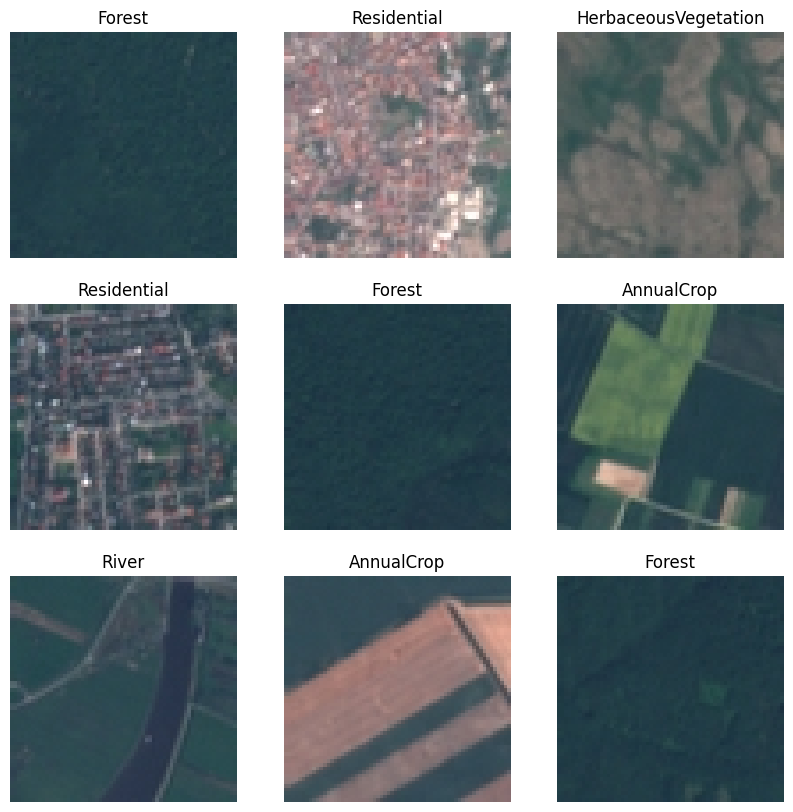

In [9]:
# Step 5: Verify Data
def show_sample(ds):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(ds.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(CLASS_NAMES[label.numpy()])
        plt.axis("off")
    plt.show()


show_sample(ds_train)

In [10]:
# Step 6: Preprocessing
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)  # EfficientNet normalization
    return image, label

In [11]:
# Step 7: Data Augmentation
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.05)
])

In [12]:

from tensorflow.keras.applications.efficientnet import preprocess_input
# Step 8: Prepare Data Pipelines
def prepare_ds(ds, augment=False):
    ds = ds.shuffle(1000)  # Added shuffling
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x), y),
                    tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_train = prepare_ds(ds_train, augment=True)
ds_val = prepare_ds(ds_val)
ds_test = prepare_ds(ds_test)

In [13]:
# Step 9: Build Model
def create_model():
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 1,681,466 (6.41 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [14]:

# Step 10: Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.LearningRateScheduler(
        lambda epoch, lr: lr * 0.97 if epoch > 10 else lr
    )
]

In [15]:
# Step 11: Train Model
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 241s 350ms/step - accuracy: 0.6988 - loss: 0.9778 - val_accuracy: 0.9449 - val_loss: 0.1664 - learning_rate: 1.0000e-04
Epoch 2/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 210s 293ms/step - accuracy: 0.9252 - loss: 0.2363 - val_accuracy: 0.9556 - val_loss: 0.1341 - learning_rate: 1.0000e-04
Epoch 3/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 171s 289ms/step - accuracy: 0.9423 - loss: 0.1796 - val_accuracy: 0.9622 - val_loss: 0.1200 - learning_rate: 1.0000e-04
Epoch 4/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 174s 294ms/step - accuracy: 0.9483 - loss: 0.1606 - val_accuracy: 0.9635 - val_loss: 0.1126 - learning_rate: 1.0000e-04
Epoch 5/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 175s 296ms/step - accuracy: 0.9583 - loss: 0.1238 - val_accuracy: 0.9647 - val_loss: 0.1062 - learning_rate: 1.0000e-04
Epoch 6/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 203s 298ms/step - accuracy: 0.9588 - loss: 0.1232 - val_accuracy: 0.9706 - val_loss: 0.0973 - learning_rate: 1.0000e-04
Epoch 7/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
# Step 12: Evaluate Model
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test Accuracy: {test_acc:.2f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9725 - loss: 0.0891
Test Accuracy: 0.98


In [17]:
# Step 13: Generate Predictions
y_true = []
y_pred = []
for images, labels in ds_test:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.97      0.96       437
              Forest       0.99      1.00      0.99       436
HerbaceousVegetation       0.97      0.97      0.97       473
             Highway       0.96      0.96      0.96       379
          Industrial       0.98      0.99      0.99       372
             Pasture       0.98      0.96      0.97       301
       PermanentCrop       0.96      0.94      0.95       393
         Residential       0.99      1.00      0.99       454
               River       0.97      0.96      0.97       353
             SeaLake       0.99      1.00      0.99       452

            accuracy                           0.98      4050
           macro avg       0.98      0.97      0.97      4050
        weighted avg       0.98      0.98      0.98      4050



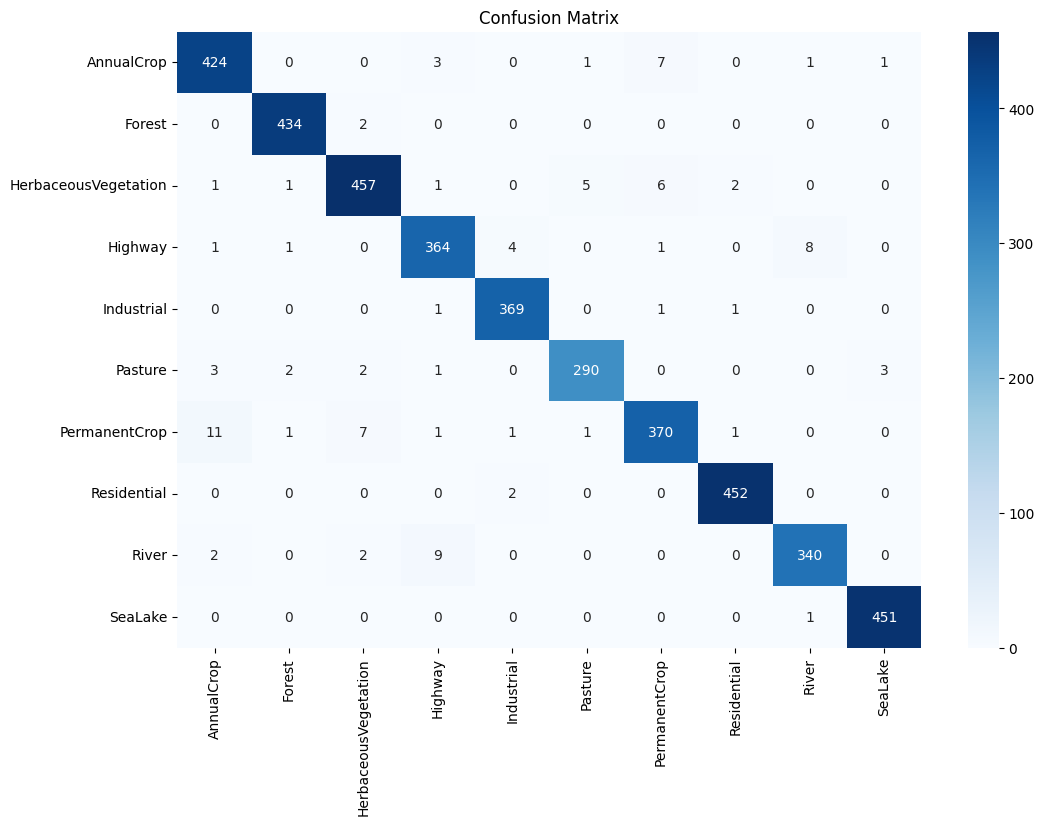

In [18]:
# Step 14: Show Results
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


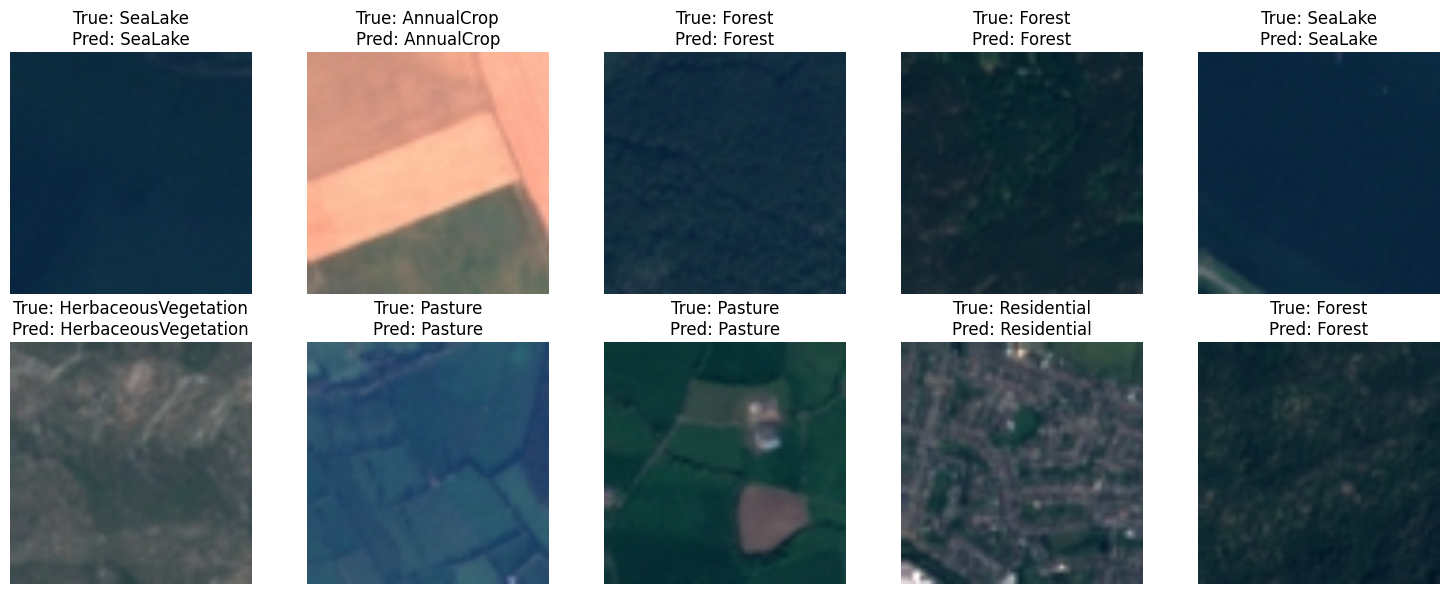

In [30]:

batch_number = 1  # change this number (0, 1, 2, ...) to view different images

plt.figure(figsize=(15, 6))

for images, labels in ds_test.unbatch().batch(10).skip(batch_number).take(1):
    preds = model.predict(images)

    display_images = images.numpy()
    display_images -= display_images.min()
    display_images /= display_images.max()
    display_images *= 255
    display_images = display_images.astype(np.uint8)

    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(display_images[i])
        plt.title(f"True: {CLASS_NAMES[labels[i]]}\nPred: {CLASS_NAMES[np.argmax(preds[i])]}")
        plt.axis('off')

plt.tight_layout()
plt.show()
